<a href="https://colab.research.google.com/github/Prasanna3528/SentimentAnalysis_Project/blob/main/Project_Code_22083075.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### Import Libraries

In [ ]:
# Import the libraries that are needed for this code
import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning)
import pandas as pd
import numpy as np
import nltk
import re
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from wordcloud import WordCloud
from collections import Counter
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.svm import SVC
from sklearn.naive_bayes import MultinomialNB
from sklearn.preprocessing import LabelEncoder
from xgboost import XGBClassifier
from sklearn.ensemble import RandomForestClassifier

### Loading The Data

In [ ]:
# Defining path to the data via GitHub link and Reading into a dataframe
RevDatafilepath = 'https://raw.githubusercontent.com/Prasanna3528/SentimentAnalysis_Project/refs/heads/main/Womens%20Clothing%20E-Commerce%20Reviews.csv'
Reviews_Data = pd.read_csv(RevDatafilepath)
# Showing the first 5 records of the dataset
print(Reviews_Data.head())

      Id  Clothing ID  Age                              Title  \
0  14746            0   26                                NaN   
1  22742            1   50    Love this under-all cami tank ?   
2  22743            1   36                       Staple tank!   
3  22749            1   24        Love but also very annoying   
4    876            2   28  Gorgeous top, straps way too long   

                                         Review Text  Rating  Recommended IND  \
0                                                NaN       5                1   
1  Originally i bought this in black and white. r...       5                1   
2  Love this tank. material and fit are great. lo...       5                1   
3  I love this tank, it is so comfortable but it ...       2                0   
4  I just adore this top! it is so comfy and styl...       4                1   

   Positive Feedback Count Division Name Department Name Class Name  
0                        0       General         Jac

### Dataset Description

In [ ]:
# Generating statistics for Numerical columns in the dataset
Reviews_Data.describe()

,Id,Clothing ID,Age,Rating,Recommended IND,Positive Feedback Count
count,23486.000000,23486.000000,23486.000000,23486.000000,23486.000000,23486.000000
mean,11742.500000,918.118709,43.198544,4.196032,0.822362,2.535936
std,6779.968547,203.298980,12.279544,1.110031,0.382216,5.702202
min,0.000000,0.000000,18.000000,1.000000,0.000000,0.000000
25%,5871.250000,861.000000,34.000000,4.000000,1.000000,0.000000
50%,11742.500000,936.000000,41.000000,5.000000,1.000000,1.000000
75%,17613.750000,1078.000000,52.000000,5.000000,1.000000,3.000000
max,23485.000000,1205.000000,99.000000,5.000000,1.000000,122.000000


In [ ]:
# Printing the shape of the original dataset
nr, nc = Reviews_Data.shape
print(f"The shape of the original dataset is {nr} reviews with {nc} columns.")

The shape of the original dataset is 23486 reviews with 11 columns.


In [ ]:
# Printing the null values in each column
Reviews_Data.isna().sum()

,0
Id,0
Clothing ID,0
Age,0
Title,3810
Review Text,845
Rating,0
Recommended IND,0
Positive Feedback Count,0
Division Name,14
Department Name,14


In [ ]:
# printing the datatypes of the each column
Reviews_Data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 23486 entries, 0 to 23485
Data columns (total 11 columns):
 #   Column                   Non-Null Count  Dtype 
---  ------                   --------------  ----- 
 0   Id                       23486 non-null  int64 
 1   Clothing ID              23486 non-null  int64 
 2   Age                      23486 non-null  int64 
 3   Title                    19676 non-null  object
 4   Review Text              22641 non-null  object
 5   Rating                   23486 non-null  int64 
 6   Recommended IND          23486 non-null  int64 
 7   Positive Feedback Count  23486 non-null  int64 
 8   Division Name            23472 non-null  object
 9   Department Name          23472 non-null  object
 10  Class Name               23472 non-null  object
dtypes: int64(6), object(5)
memory usage: 2.0+ MB


### Data Pre-Processing

In [ ]:
# Declaring the columns that doesnt Affect the Analysis
Col_remove_Revdata = ['Id', 'Clothing ID','Title','Department Name','Class Name']
# Removing the columns from the dataset
Reviews_Data = Reviews_Data.drop(columns=Col_remove_Revdata, errors='ignore')

In [ ]:
# Removing rows where "Review Text" is empty
PP_Reviews_Data = Reviews_Data[Reviews_Data['Review Text'].notna() & (Reviews_Data['Review Text'] != '')]
# Remove rows where the 'Review' column has NaN values
PP_Reviews_Data = PP_Reviews_Data.dropna(subset=['Division Name'])

In [ ]:
# Printing the shape of the original dataset after missing values removal
nr_pp, nc_pp = PP_Reviews_Data.shape
print(f"The shape of the dataset after pre-processing is {nr_pp} reviews with {nc_pp} columns.")

The shape of the dataset after pre-processing is 22628 reviews with 6 columns.


In [ ]:
# Checking for the null values in each column after pre-processing
PP_Reviews_Data.isna().sum()

,0
Age,0
Review Text,0
Rating,0
Recommended IND,0
Positive Feedback Count,0
Division Name,0


In [ ]:
# Download the 'stopwords' & 'wordnet' resource from nltk
nltk.download('stopwords')
nltk.download('wordnet')
# Initialize a WordNetLemmatizer object
lem_rev_Data = WordNetLemmatizer()
# Get the list of English stopwords from nltk
stop_words = set(stopwords.words('english'))

# function to preprocess text reviews
def preprocess_text(text):

    """
    Preprocesses the text reviews by performing the following steps:
    1. Converts the text to lowercase.
    2. Removes any punctuation and numbers.
    3. Tokenizes the text into individual words.
    4. Removes common words like 'the', 'and' from the text.
    5. Lemmatizes which means it reduces words to their base form.
    6. Joins the processed words back into a single string.

    Parameters:
    text (str): The input text string to be preprocessed.

    Returns:
    str: The processed text as a single string
    """
    # Converts to lowercase
    text_lowcase = text.lower()
    # Remove punctuation and numbers
    text_rem_pn = re.sub(r'[^a-z\s]', '', text_lowcase)
    # Tokenize the text
    Tokens_Rev = text_rem_pn.split()
    # Remove stop words and lemmatize
    lemWords_Rev = [lem_rev_Data.lemmatize(word) for word in Tokens_Rev if word not in stop_words]
    # Join words back into a single string
    return ' '.join(lemWords_Rev)

# using preprocessing function to the text column
PP_Reviews_Data['Rev_PP_Text'] = PP_Reviews_Data['Review Text'].apply(preprocess_text)

# showing the new column with the cleaned text column
PP_Reviews_Data[['Review Text', 'Rev_PP_Text']]

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...


,Review Text,Rev_PP_Text
1,Originally i bought this in black and white. r...,originally bought black white recently purchas...
2,Love this tank. material and fit are great. lo...,love tank material fit great love reversible h...
3,"I love this tank, it is so comfortable but it ...",love tank comfortable flaw roll every time wal...
4,I just adore this top! it is so comfy and styl...,adore top comfy stylish wear little purple car...
5,I love this sweater. definite classic. i get l...,love sweater definite classic get lot compliment
...,...,...
23480,"Great material, and i like the idea of a scoop...",great material like idea scoop v neck combinat...
23482,I love these pants. i have them in navy and ca...,love pant navy carbon navy color seems run big...
23483,These are super soft and relaxed. i have them ...,super soft relaxed navy lavender lb ordered fi...
23484,Just received my second pair of pilcro in the ...,received second pair pilcro red loved color ne...


In [ ]:
# Function to determine sentiment based on rating
def determine_sentiment(Rating):
    """
    Determines the sentiment based on a rating.

    Parameters:
    Rating (int or float): A numerical value representing the rating

    Returns:
    str: A string indicating the sentiment:
         - "Positive" if the rating is greater than 3
         - "Neutral" if the rating is equal to 3
         - "Negative" if the rating is less than 3
    """
    if Rating > 3:
        return "Positive"
    elif Rating == 3:
        return "Neutral"
    else:
        return "Negative"

# using function to create the new Sentiment column
PP_Reviews_Data['Sentiment'] = PP_Reviews_Data['Rating'].apply(determine_sentiment)

In [ ]:
#Adding new column for the length of the comment
PP_Reviews_Data['review_length'] = PP_Reviews_Data['Review Text'].apply(len)

In [ ]:
# Checking and removing the duplicate rows
print(f"Number of duplicate rows before removal: {PP_Reviews_Data.duplicated().sum()}")
PP_Reviews_Data = PP_Reviews_Data.drop_duplicates()
print(f"Number of duplicate rows after removal: {PP_Reviews_Data.duplicated().sum()}")

Number of duplicate rows before removal: 3
Number of duplicate rows after removal: 0


In [ ]:
# show the first 5 rows of the updated DataFrame
PP_Reviews_Data.head()

,Age,Review Text,Rating,Recommended IND,Positive Feedback Count,Division Name,Rev_PP_Text,Sentiment,review_length
1,50,Originally i bought this in black and white. r...,5,1,0,Initmates,originally bought black white recently purchas...,Positive,386
2,36,Love this tank. material and fit are great. lo...,5,1,0,Initmates,love tank material fit great love reversible h...,Positive,88
3,24,"I love this tank, it is so comfortable but it ...",2,0,1,Initmates,love tank comfortable flaw roll every time wal...,Negative,140
4,28,I just adore this top! it is so comfy and styl...,4,1,0,General,adore top comfy stylish wear little purple car...,Positive,365
5,36,I love this sweater. definite classic. i get l...,5,1,0,General,love sweater definite classic get lot compliment,Positive,71


In [ ]:
# Datatypes of the Datasets after pre-processing
print(PP_Reviews_Data.info())

<class 'pandas.core.frame.DataFrame'>
Index: 22625 entries, 1 to 23485
Data columns (total 9 columns):
 #   Column                   Non-Null Count  Dtype 
---  ------                   --------------  ----- 
 0   Age                      22625 non-null  int64 
 1   Review Text              22625 non-null  object
 2   Rating                   22625 non-null  int64 
 3   Recommended IND          22625 non-null  int64 
 4   Positive Feedback Count  22625 non-null  int64 
 5   Division Name            22625 non-null  object
 6   Rev_PP_Text              22625 non-null  object
 7   Sentiment                22625 non-null  object
 8   review_length            22625 non-null  int64 
dtypes: int64(5), object(4)
memory usage: 1.7+ MB
None


In [ ]:
# Printing the columns present in the dataset after pre-processing
PP_Reviews_Data.columns

Index(['Age', 'Review Text', 'Rating', 'Recommended IND',
       'Positive Feedback Count', 'Division Name', 'Rev_PP_Text', 'Sentiment',
       'review_length'],
      dtype='object')

### Exploratory Data Analysis

###### Sentiment Distribution of Reviews through Bar Plot

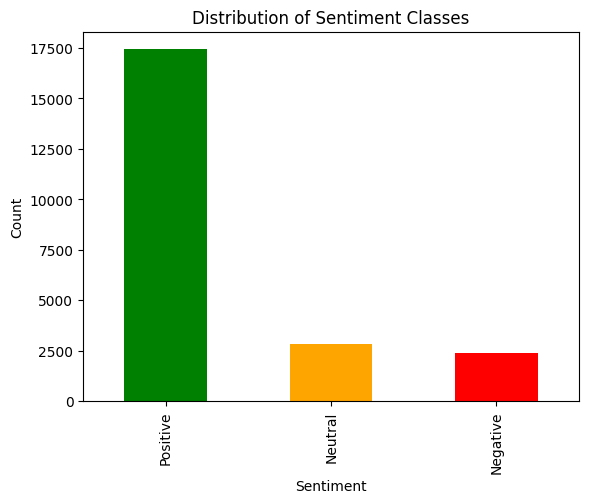

In [ ]:
# Plotting the bar chart for sentiment distribution
PP_Reviews_Data['Sentiment'].value_counts().plot(kind='bar',
                                            color=['green', 'orange', 'red'])

# Setting the plot title and axis titles
plt.title('Distribution of Sentiment Classes')
plt.xlabel('Sentiment')
plt.ylabel('Count')
# Show the plot
plt.show()


###### Sentiment Class Distribution of Reviews

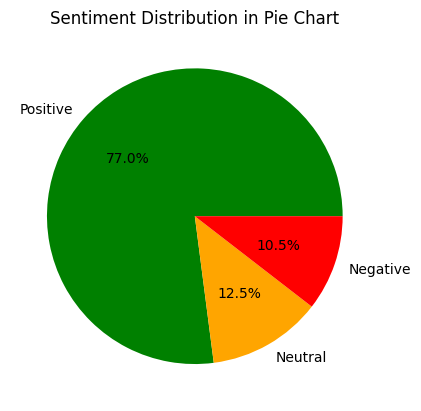

In [ ]:
# Plotting a pie chart to visualize the proportion of each sentiment class
PP_Reviews_Data['Sentiment'].value_counts().plot(kind='pie', autopct='%1.1f%%', colors=['green', 'orange', 'red'])
# Adding a title to the pie chart
plt.title('Sentiment Distribution in Pie Chart')
plt.ylabel('')
# Showing the plot
plt.show()


###### Rating Distribution of Reviews through Pie Plot

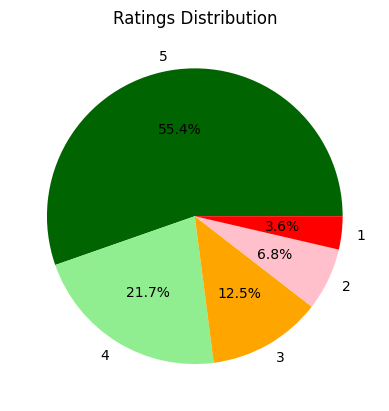

In [ ]:
#Plotting a pie chart to visualize the distribution of ratings
PP_Reviews_Data['Rating'].value_counts().plot(kind='pie',
                          autopct='%1.1f%%', colors=['darkgreen','lightgreen',
                                                     'orange','pink' ,'red'])
# Setting the plot titles
plt.title('Ratings Distribution')
plt.ylabel('')
# Show the plot
plt.show()


###### Histogram Visualization of Review Length

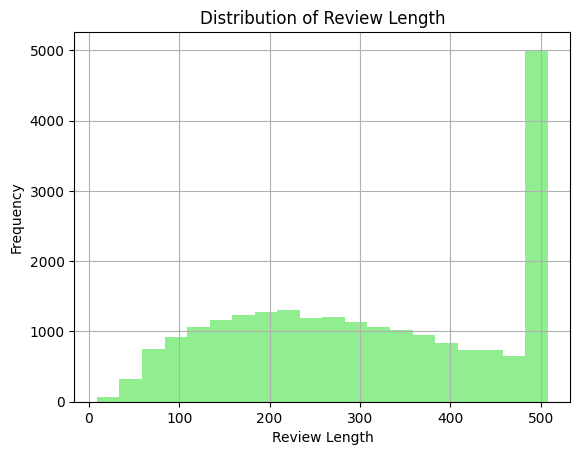

In [ ]:
# Plotting a histogram to visualize the distribution of review lengths
PP_Reviews_Data['review_length'].hist(bins=20, color='lightgreen')
# Setting Plot titles and Axis labels
plt.title('Distribution of Review Length')
plt.xlabel('Review Length')
plt.ylabel('Frequency')
#show the plot
plt.show()

###### BoxPlot for Rating

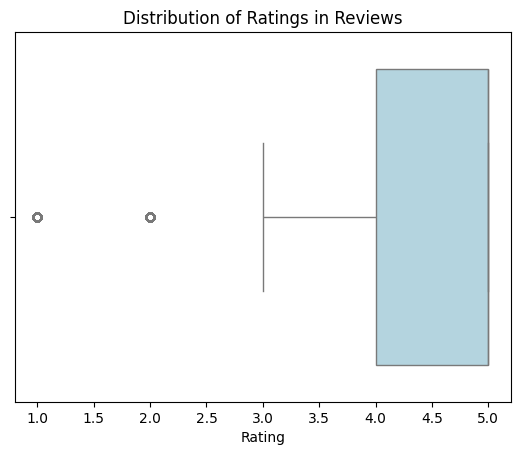

In [ ]:
# Create a boxplot for the 'Rating' column
sns.boxplot(data=PP_Reviews_Data, x='Rating', color='lightblue')
# Add title and labels
plt.title('Distribution of Ratings in Reviews')
plt.xlabel('Rating')
# Display the plot
plt.show()

##### Distribution of Division Name through Barplot

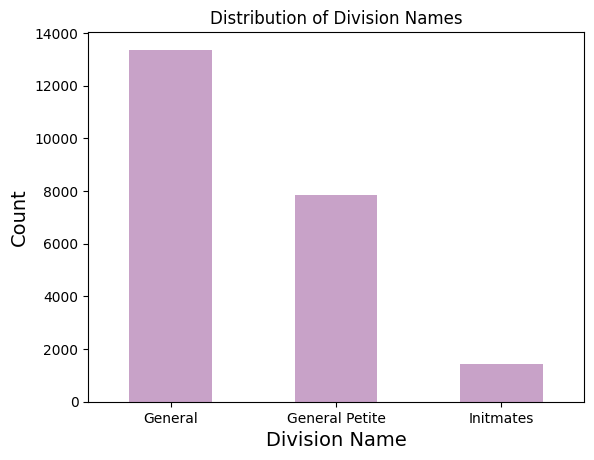

In [ ]:
# Plotting a bar plot for the 'Division Name'
PP_Reviews_Data['Division Name'].value_counts().plot(kind='bar', color='#C8A2C8')
# Adding the plot titles and axis labels
plt.title('Distribution of Division Names')
plt.xlabel('Division Name',fontsize = 14)
plt.ylabel('Count',fontsize = 14)
# Rotating the X-labels for better visibility
plt.xticks(rotation=0)
# Display the plot
plt.show()

###### Distribution of Sentiment Across Divisions

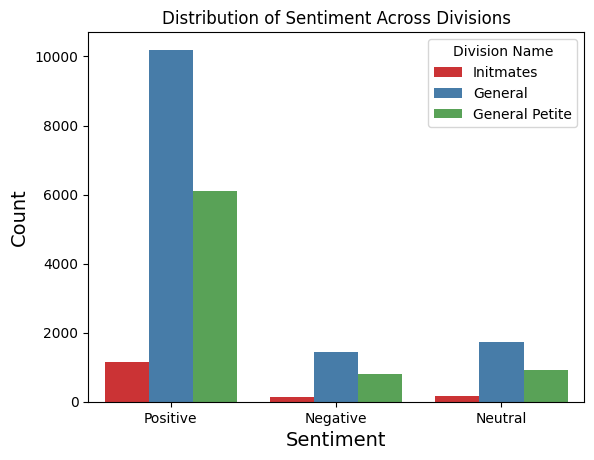

In [ ]:
# Create a count plot for 'Sentiment' with 'Division Name' as the hue
sns.countplot(data=PP_Reviews_Data, x='Sentiment',
              hue='Division Name', palette='Set1')
# Adding the plot titles and axis labels
plt.title('Distribution of Sentiment Across Divisions')
plt.xlabel('Sentiment',fontsize = 14)
plt.ylabel('Count',fontsize = 14)
# Show the plot
plt.show()


###### Word cloud for Sentiments

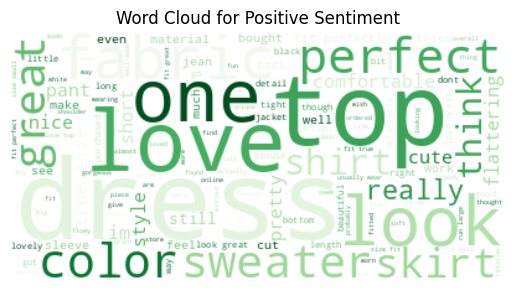

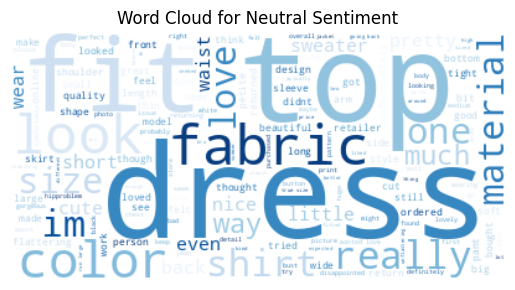

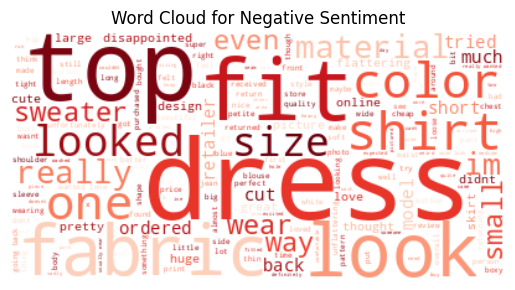

In [ ]:
# Word cloud for positive sentiment
pos_rev = ' '.join(PP_Reviews_Data[PP_Reviews_Data['Sentiment'] == 'Positive']['Rev_PP_Text'])
wrdcl_pos_rev = WordCloud(background_color='white', colormap='Greens').generate(pos_rev)
plt.imshow(wrdcl_pos_rev, interpolation='bilinear')
plt.axis('off')
# Set the title for the plot
plt.title('Word Cloud for Positive Sentiment')
# Display the plot
plt.show()

# Word cloud for Neutral sentiment
neut_rev = ' '.join(PP_Reviews_Data[PP_Reviews_Data['Sentiment'] == 'Neutral']['Rev_PP_Text'])
wrdcl_neut_rev = WordCloud(background_color='white', colormap='Blues').generate(neut_rev)
plt.imshow(wrdcl_neut_rev, interpolation='bilinear')
plt.axis('off')
# Set the title for the plot
plt.title('Word Cloud for Neutral Sentiment')
# Display the plot
plt.show()

# Word cloud for negative sentiment
neg_rev = ' '.join(PP_Reviews_Data[PP_Reviews_Data['Sentiment'] == 'Negative']['Rev_PP_Text'])
wrdcl_neg_rev = WordCloud(background_color='white', colormap='Reds').generate(neg_rev)
plt.imshow(wrdcl_neg_rev, interpolation='bilinear')
plt.axis('off')
# Set the title for the plot
plt.title('Word Cloud for Negative Sentiment')
plt.show()


###### Correlation Heatmap of Ratings and Review Length

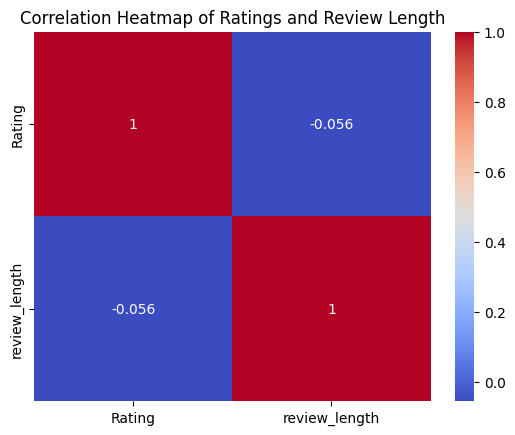

In [ ]:
# Specifing the columns to be included in the correlation matrix
numerical_columns = ['Rating', 'review_length']
# Calculating the correlation matrix
correlation_matrix = PP_Reviews_Data[numerical_columns].corr()
# Plotting the correlation heatmap
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm')
# Adding a title to the heatmap
plt.title('Correlation Heatmap of Ratings and Review Length')
#Show the plot
plt.show()


### Implementation of Models

In [ ]:
# Function to Evaluate the models
def eval(model, revtext_train, revtext_test, sen_col_train, sen_col_test):
    """
    Evaluate the performance of a trained machine learning model
    using classification metrics and confusion matrix.

    Parameters:
    - model: Trained machine learning model
    - revtext_train: Feature matrix for the training data.
    - revtext_test: Feature matrix for the test data.
    - sen_col_train: True labels for the training data.
    - sen_col_test: True labels for the test data.

    This function prints the classification report for both the training and test sets,
    and displays a confusion matrix for the test set using a heatmap.

    """
    # Predict the labels for the test set using the trained model
    y_pred = model.predict(revtext_test)
     # Predict the labels for the training set using the trained model
    y_pred_train = model.predict(revtext_train)

    # Print classification metrics for the test set
    print("classification metrics for the Testing Data:")
    print(classification_report(sen_col_test, y_pred))
    # Print classification metrics for the training set
    print("classification metrics for the Training Data:")
    print(classification_report(sen_col_train, y_pred_train))

    #Compute the confusion matrix for the test set
    confmat_cal = confusion_matrix(sen_col_test, y_pred)

    # Plot the confusion matrix through heatmap
    plt.figure(figsize=(6, 6))
    sns.heatmap(confmat_cal, annot=True, fmt='d', cmap='Blues',
                xticklabels=model.classes_, yticklabels=model.classes_)
    # adding the plot titles and axis labels
    plt.title("Confusion Matrix")
    plt.ylabel("Original Sentiment")
    plt.xlabel("Predicted Sentiment")
    # Show the plot
    plt.show()

In [ ]:
# declaring the predictors and target variabels
revtext = PP_Reviews_Data["Rev_PP_Text"]
sen_col = PP_Reviews_Data["Sentiment"]

# splitting the dataset into training and testing sets
revtext_train, revtext_test, sen_col_train, sen_col_test = train_test_split(
    revtext, sen_col, test_size=0.2, stratify=sen_col, random_state=3075
)

# Transform data using TF-IDF
tfidf_vec_rev = TfidfVectorizer()
revtext_train_tf_idf = tfidf_vec_rev.fit_transform(revtext_train)
revtext_test_tf_idf = tfidf_vec_rev.transform(revtext_test)

Fitting 5 folds for each of 1 candidates, totalling 5 fits
Best Parameters for Logistic Regression: {'C': 10}
classification metrics for the Testing Data:
              precision    recall  f1-score   support

    Negative       0.56      0.46      0.50       474
     Neutral       0.38      0.29      0.33       565
    Positive       0.89      0.95      0.92      3486

    accuracy                           0.81      4525
   macro avg       0.61      0.56      0.58      4525
weighted avg       0.79      0.81      0.80      4525

classification metrics for the Training Data:
              precision    recall  f1-score   support

    Negative       0.93      0.87      0.90      1896
     Neutral       0.90      0.78      0.84      2258
    Positive       0.96      0.99      0.97     13946

    accuracy                           0.95     18100
   macro avg       0.93      0.88      0.90     18100
weighted avg       0.95      0.95      0.95     18100



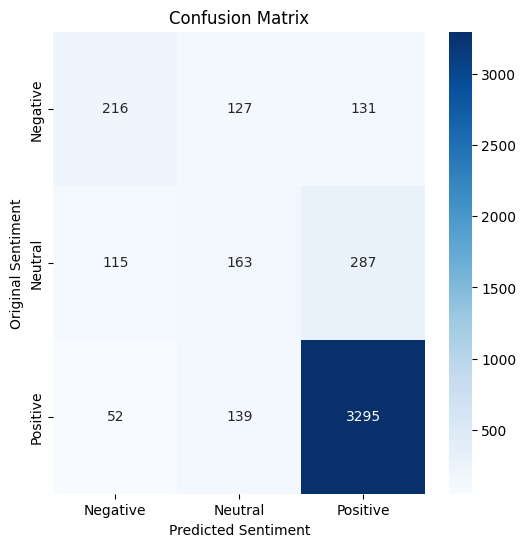

In [ ]:
# declaring yperparameter grid for Logistic Regression
Log_Reg_Mod_params = {
    'C': [10]
}

# Defining the Logistic Regression model with specified parameters
Log_Reg_Mod_Rev = LogisticRegression(
    max_iter=1000,
    random_state=3075,
    solver='lbfgs',
    penalty='l2',
)

# Initializing RandomizedSearchCV to search for the best hyperparameters
Log_Reg_Mod_search = RandomizedSearchCV(
    Log_Reg_Mod_Rev,
    Log_Reg_Mod_params,
    n_iter=1,
    scoring='accuracy',
    cv=5,
    random_state=3075,
    verbose=2,
    n_jobs=-1
)

# Fitting the RandomizedSearchCV on the training data
Log_Reg_Mod_search.fit(revtext_train_tf_idf, sen_col_train)

# Printing the best hyperparameters found
print("Best Parameters for Logistic Regression:",
      Log_Reg_Mod_search.best_params_)
# Extracting the best model from the RandomizedSearchCV results
best_Log_Reg_Mod_Rev = Log_Reg_Mod_search.best_estimator_
# Evaluating the best Logistic Regression model on the training and test data
eval(best_Log_Reg_Mod_Rev, revtext_train_tf_idf,
     revtext_test_tf_idf, sen_col_train, sen_col_test)

Fitting 5 folds for each of 1 candidates, totalling 5 fits
[CV] END ..................................C=100, kernel=rbf; total time= 2.3min
[CV] END ..................................C=100, kernel=rbf; total time= 2.3min
[CV] END ..................................C=100, kernel=rbf; total time= 2.3min
[CV] END ..................................C=100, kernel=rbf; total time= 2.3min
[CV] END ..................................C=100, kernel=rbf; total time= 2.3min
Best Parameters for SVM: {'kernel': 'rbf', 'C': 100}
classification metrics for the Testing Data:
              precision    recall  f1-score   support

    Negative       0.61      0.45      0.52       474
     Neutral       0.42      0.24      0.31       565
    Positive       0.87      0.97      0.92      3486

    accuracy                           0.82      4525
   macro avg       0.64      0.55      0.58      4525
weighted avg       0.79      0.82      0.80      4525

classification metrics for the Training Data:
           

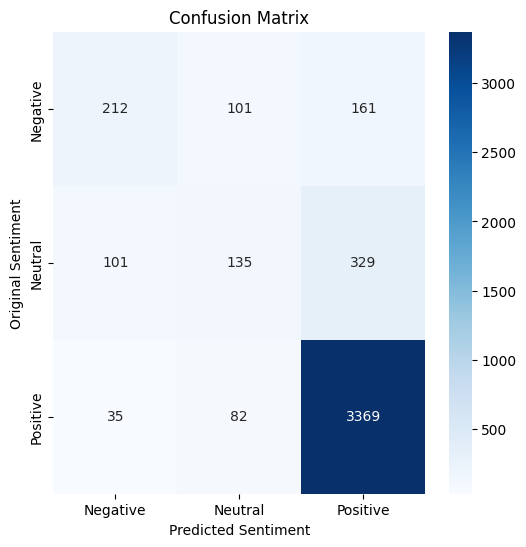

In [ ]:
#hyperparameters for the SVM model
SVM_Mod_Params = {
    'C': [100],
    'kernel': ['rbf']
}
# Initialize the SVM model
SVM_Mod_Rev = SVC(random_state=3075)
# Set up a RandomizedSearchCV for hyperparameter tuning
SVM_Mod_Search = RandomizedSearchCV(SVM_Mod_Rev, SVM_Mod_Params,
                                    n_iter=1, scoring='accuracy',
                                    cv=5, random_state=3075, verbose=2)
# Fit the RandomizedSearchCV on the training data
SVM_Mod_Search.fit(revtext_train_tf_idf, sen_col_train)
# print the best parameters found during the search process
print("Best Parameters for SVM:", SVM_Mod_Search.best_params_)
# Get the best model after hyperparameter tuning
best_SVM_Mod_Rev = SVM_Mod_Search.best_estimator_
# Evaluating the best SVM model on the training and test data
eval(best_SVM_Mod_Rev, revtext_train_tf_idf, revtext_test_tf_idf,
     sen_col_train, sen_col_test)

Fitting 5 folds for each of 1 candidates, totalling 5 fits
[CV] END min_samples_leaf=1, min_samples_split=2, n_estimators=200; total time=  51.8s
[CV] END min_samples_leaf=1, min_samples_split=2, n_estimators=200; total time=  50.8s
[CV] END min_samples_leaf=1, min_samples_split=2, n_estimators=200; total time=  51.6s
[CV] END min_samples_leaf=1, min_samples_split=2, n_estimators=200; total time=  51.0s
[CV] END min_samples_leaf=1, min_samples_split=2, n_estimators=200; total time=  51.2s
Best Parameters for Random Forest: {'n_estimators': 200, 'min_samples_split': 2, 'min_samples_leaf': 1}
classification metrics for the Testing Data:
              precision    recall  f1-score   support

    Negative       0.75      0.10      0.18       474
     Neutral       0.31      0.01      0.02       565
    Positive       0.78      1.00      0.88      3486

    accuracy                           0.78      4525
   macro avg       0.62      0.37      0.36      4525
weighted avg       0.72      0.

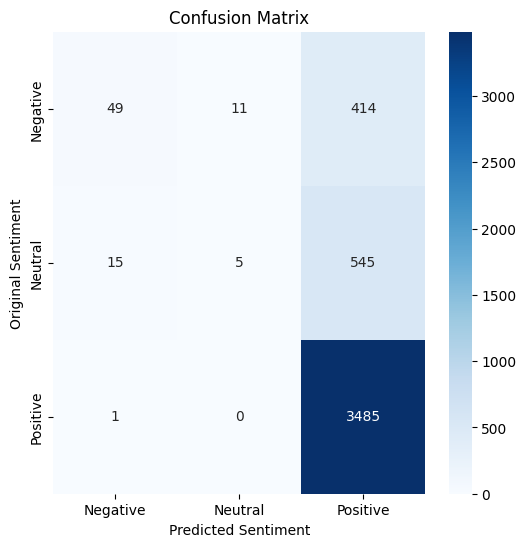

In [ ]:
#hyperparameters for the Random Forest model
Ranfor_Mod_Params = {
    'n_estimators': [200],
    'min_samples_split': [2],
    'min_samples_leaf': [1]
}
# Initialize the Random Forest model
Ranfor_Mod_Rev = RandomForestClassifier(random_state=3075)
# Set up a RandomizedSearchCV for hyperparameter tuning
Ranfor_Mod_Search = RandomizedSearchCV(Ranfor_Mod_Rev, Ranfor_Mod_Params,
                                       n_iter=1,
                        scoring='accuracy', cv=5, random_state=3075, verbose=2)
# Fit the RandomizedSearchCV on the training data
Ranfor_Mod_Search.fit(revtext_train_tf_idf, sen_col_train)
# print the best parameters found during the search process
print("Best Parameters for Random Forest:", Ranfor_Mod_Search.best_params_)
# Get the best model after hyperparameter tuning
best_Ranfor_Mod_Rev = Ranfor_Mod_Search.best_estimator_
# Evaluating the best Random Forest model on the training and test data
eval(best_Ranfor_Mod_Rev, revtext_train_tf_idf, revtext_test_tf_idf, sen_col_train, sen_col_test)

Fitting 5 folds for each of 1 candidates, totalling 5 fits
[CV] END ...learning_rate=0.2, max_depth=3, n_estimators=200; total time=  12.0s
[CV] END ...learning_rate=0.2, max_depth=3, n_estimators=200; total time=  12.2s
[CV] END ...learning_rate=0.2, max_depth=3, n_estimators=200; total time=  12.2s
[CV] END ...learning_rate=0.2, max_depth=3, n_estimators=200; total time=  12.1s
[CV] END ...learning_rate=0.2, max_depth=3, n_estimators=200; total time=  12.2s
Best Parameters for XGBoost: {'n_estimators': 200, 'max_depth': 3, 'learning_rate': 0.2}
classification metrics for the Testing Data:
              precision    recall  f1-score   support

           0       0.64      0.35      0.45       474
           1       0.41      0.16      0.23       565
           2       0.84      0.98      0.91      3486

    accuracy                           0.81      4525
   macro avg       0.63      0.50      0.53      4525
weighted avg       0.77      0.81      0.78      4525

classification metric

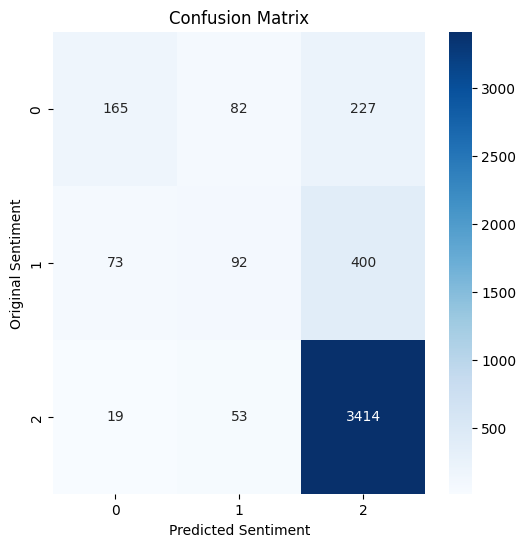

In [ ]:
#hyperparameters for the XGBoost model
XGB_Mod_Params = {
    'n_estimators': [200],
    'max_depth': [3],
    'learning_rate': [0.2],
}
# Initialize the XGB model
XGB_Mod_Rev = XGBClassifier(random_state=3075)
# Set up a RandomizedSearchCV for hyperparameter tuning
XGB_Mod_Search = RandomizedSearchCV(
    XGB_Mod_Rev,
    XGB_Mod_Params,
    n_iter=1,
    scoring='accuracy',
    cv=5,
    random_state=3075,
    verbose=2
)

# Assuming y is your target variable
le = LabelEncoder()
# Fit and transform the labels into numerical values
sen_col_train = le.fit_transform(sen_col_train)
sen_col_test = le.fit_transform(sen_col_test)


# Fit the RandomizedSearchCV on the training data
XGB_Mod_Search.fit(revtext_train_tf_idf, sen_col_train)
# print the best parameters found during the search process
print("Best Parameters for XGBoost:", XGB_Mod_Search.best_params_)
# Get the best model after hyperparameter tuning
best_XGB_Mod_Rev = XGB_Mod_Search.best_estimator_
# Evaluating the best XGB model on the training and test data
eval(best_XGB_Mod_Rev, revtext_train_tf_idf, revtext_test_tf_idf,
     sen_col_train, sen_col_test)
